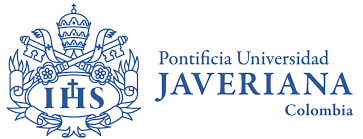

# Taller Spark MLlib – Métodos No Supervisados (Clustering y PCA)

**Curso:** Computación de Alto Desempeño

**Estudiante:** Sebastian Fanchi

**Fecha:** 20/11/2025

---

## Descripción general

En este cuaderno se desarrolla técnicas e implementación de **aprendizaje no supervisado con Spark MLlib**, aplicándolo a un dataset real: **Titanic**.

Se realizarán los siguientes procesos:

### Preprocesamiento
- Selección y limpieza de variables  
- Imputación  
- Conversión categórica a numérica  
- Escalamiento

### Algoritmos No Supervisados
1. **K-Means Clustering**
2. **PCA — Principal Component Analysis**

### Evaluación
- Métrica **Silhouette Score**

### Cierre
- Conclusiones del análisis realizado

In [4]:
# Inicialización de SparkSession conectada al clúster

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Taller_NoSupervisado_Titanic")
    .master("spark://10.43.100.119:7077")
    .config("spark.submit.deployMode", "client")
    .config("spark.driver.bindAddress", "0.0.0.0")
    .config("spark.driver.host", "localhost")
    .getOrCreate()
)

## 1. Carga y exploración del dataset Titanic

Usaremos nuevamente el dataset Titanic para actividades de ML No Supervisado. Las variables de interés serán:

- `Pclass`  
- `Sex`  
- `Age`  
- `Fare`  
- `SibSp`  
- `Parch`

In [5]:
from pyspark.sql import functions as F

data_path = "data/titanic.csv"

titanic_raw = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv(data_path)
)

titanic_raw.printSchema()
titanic_raw.show(5)
print("Total filas:", titanic_raw.count())

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|   

## 2. Limpieza y preparación de datos

### Objetivos:
- Imputar valores faltantes  
- Convertir variables categóricas a numéricas  
- Seleccionar las columnas útiles para clustering  

Usaremos:

- `Age` (imputada con media)  
- `Fare`  
- `Pclass`  
- `SibSp`  
- `Parch`  
- `Sex` → indexada (0/1)


In [6]:
# Imputación: media y moda

age_mean = titanic_raw.select(F.mean("Age")).first()[0]

titanic_no_nulls = (
    titanic_raw
    .fillna({"Age": age_mean})
    .dropna(subset=["Fare"])
)

titanic_no_nulls.count()

891

### 2.1 Conversión de variables categóricas (StringIndexer)

Convertiremos:

- `Sex` → numérico (0/1)

In [8]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(
    inputCol="Sex",
    outputCol="SexIndexed"
)

titanic_indexed = indexer.fit(titanic_no_nulls).transform(titanic_no_nulls)
titanic_indexed.select("Sex", "SexIndexed").show(10)

+------+----------+
|   Sex|SexIndexed|
+------+----------+
|  male|       0.0|
|female|       1.0|
|female|       1.0|
|female|       1.0|
|  male|       0.0|
|  male|       0.0|
|  male|       0.0|
|  male|       0.0|
|female|       1.0|
|female|       1.0|
+------+----------+
only showing top 10 rows



## 3. Ensamble de características y escalamiento

Para clustering, ensamblamos un vector de columnas numéricas.

Usaremos:

- `Pclass`  
- `SexIndexed`  
- `Age`  
- `Fare`  
- `SibSp`  
- `Parch`

In [9]:
from pyspark.ml.feature import VectorAssembler

features_cols = [
    "Pclass", "SexIndexed", "Age", "Fare", "SibSp", "Parch"
]

assembler = VectorAssembler(
    inputCols=features_cols,
    outputCol="features"
)

titanic_features = assembler.transform(titanic_indexed)

titanic_features.select(features_cols + ["features"]).show(10, truncate=False)

+------+----------+-----------------+-------+-----+-----+------------------------------------------+
|Pclass|SexIndexed|Age              |Fare   |SibSp|Parch|features                                  |
+------+----------+-----------------+-------+-----+-----+------------------------------------------+
|3     |0.0       |22.0             |7.25   |1    |0    |[3.0,0.0,22.0,7.25,1.0,0.0]               |
|1     |1.0       |38.0             |71.2833|1    |0    |[1.0,1.0,38.0,71.2833,1.0,0.0]            |
|3     |1.0       |26.0             |7.925  |0    |0    |[3.0,1.0,26.0,7.925,0.0,0.0]              |
|1     |1.0       |35.0             |53.1   |1    |0    |[1.0,1.0,35.0,53.1,1.0,0.0]               |
|3     |0.0       |35.0             |8.05   |0    |0    |[3.0,0.0,35.0,8.05,0.0,0.0]               |
|3     |0.0       |29.69911764705882|8.4583 |0    |0    |[3.0,0.0,29.69911764705882,8.4583,0.0,0.0]|
|1     |0.0       |54.0             |51.8625|0    |0    |[1.0,0.0,54.0,51.8625,0.0,0.0]    

### 3.1 Escalamiento

Aplicaremos **StandardScaler** para normalizar las características.

In [10]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=False,
    withStd=True
)

scaler_model = scaler.fit(titanic_features)
titanic_scaled = scaler_model.transform(titanic_features)

titanic_scaled.select("features", "scaledFeatures").show(10, truncate=False)

+------------------------------------------+-----------------------------------------------------------------------------------------------------+
|features                                  |scaledFeatures                                                                                       |
+------------------------------------------+-----------------------------------------------------------------------------------------------------+
|[3.0,0.0,22.0,7.25,1.0,0.0]               |[3.5882109717039685,0.0,1.6920453958554,0.14589454188740145,0.9068292503182259,0.0]                  |
|[1.0,1.0,38.0,71.2833,1.0,0.0]            |[1.1960703239013228,2.0920936665593883,2.9226238655684185,1.4344612962375454,0.9068292503182259,0.0] |
|[3.0,1.0,26.0,7.925,0.0,0.0]              |[3.5882109717039685,2.0920936665593883,1.9996900132836546,0.15947782682174572,0.0,0.0]               |
|[1.0,1.0,35.0,53.1,1.0,0.0]               |[1.1960703239013228,2.0920936665593883,2.6918904024972274,1.06855174816841

# 4. K-Means Clustering

Aplicaremos K-means con distintos valores de K:

- K = 2  
- K = 3  
- K = 4

Evaluaremos con **Silhouette Score**.

In [11]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(
    predictionCol="prediction",
    featuresCol="scaledFeatures",
    metricName="silhouette"
)

results = []

for k in [2, 3, 4]:
    kmeans = KMeans(
        k=k,
        seed=42,
        featuresCol="scaledFeatures",
        predictionCol="prediction"
    )
    model = kmeans.fit(titanic_scaled)
    predictions = model.transform(titanic_scaled)
    
    silhouette = evaluator.evaluate(predictions)
    
    results.append((k, silhouette))

results

[(2, 0.369122411777685), (3, 0.3684714187827143), (4, 0.39466978556196863)]

### 4.1 Entrenamiento final con mejor K

Seleccionamos el K con mayor Silhouette.

In [12]:
best_k = max(results, key=lambda x: x[1])[0]
best_k

4

In [13]:
# Entrenar modelo con el mejor K

kmeans_final = KMeans(
    k=best_k,
    seed=42,
    featuresCol="scaledFeatures",
    predictionCol="prediction"
)

model_final = kmeans_final.fit(titanic_scaled)
predictions_final = model_final.transform(titanic_scaled)

predictions_final.select("prediction", "Pclass", "Age", "Fare").show(20)

+----------+------+-----------------+-------+
|prediction|Pclass|              Age|   Fare|
+----------+------+-----------------+-------+
|         3|     3|             22.0|   7.25|
|         0|     1|             38.0|71.2833|
|         1|     3|             26.0|  7.925|
|         0|     1|             35.0|   53.1|
|         3|     3|             35.0|   8.05|
|         3|     3|29.69911764705882| 8.4583|
|         0|     1|             54.0|51.8625|
|         1|     3|              2.0| 21.075|
|         1|     3|             27.0|11.1333|
|         1|     2|             14.0|30.0708|
|         1|     3|              4.0|   16.7|
|         0|     1|             58.0|  26.55|
|         3|     3|             20.0|   8.05|
|         1|     3|             39.0| 31.275|
|         1|     3|             14.0| 7.8542|
|         0|     2|             55.0|   16.0|
|         1|     3|              2.0| 29.125|
|         3|     2|29.69911764705882|   13.0|
|         1|     3|             31

# 5. PCA — Análisis de Componentes Principales

Aplicaremos PCA para reducir dimensiones de:

- 6 variables → 2 componentes principales

Esto permitirá visualizar clusters y analizar relaciones globales.

In [20]:
from pyspark.ml.feature import PCA as PCAml

pca = PCAml(
    k=2,
    inputCol="scaledFeatures",
    outputCol="pcaFeatures"
)

pca_model = pca.fit(titanic_scaled)
titanic_pca = pca_model.transform(titanic_scaled)

titanic_pca.select("pcaFeatures").show(10, truncate=False)

+------------------------------------------+
|pcaFeatures                               |
+------------------------------------------+
|[-1.007772901695711,1.3880656606044894]   |
|[1.4150953693880481,-0.845788577218537]   |
|[-0.5313616872879223,0.9985146256128894]  |
|[1.219739146496826,-0.6094632388739372]   |
|[-1.3918548562015223,0.4551537053675764]  |
|[-1.3710872398311305,0.678509060023983]   |
|[-0.04000361035710698,-1.9450419072445775]|
|[0.5080954796654791,3.3363825331419528]   |
|[0.6867224761505984,1.7970470824274982]   |
|[0.5662752401054324,1.0871833957152928]   |
+------------------------------------------+
only showing top 10 rows



## 5.1 Análisis exploratorio PCA

Mostramos los primeros valores proyectados a PC1 y PC2.

In [23]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

# Convertimos pcaFeatures a un ARRAY real
titanic_pca = titanic_pca.withColumn("pca_arr", vector_to_array("pcaFeatures"))

# Ahora sí podemos extraer PC1 y PC2 sin error
titanic_pca = (
    titanic_pca
    .withColumn("PC1", col("pca_arr").getItem(0))
    .withColumn("PC2", col("pca_arr").getItem(1))
)

titanic_pca.select("PC1", "PC2").show(10)

[Stage 203:>                                                        (0 + 1) / 1]

+--------------------+-------------------+
|                 PC1|                PC2|
+--------------------+-------------------+
|  -1.007772901695711| 1.3880656606044894|
|  1.4150953693880481| -0.845788577218537|
| -0.5313616872879223| 0.9985146256128894|
|   1.219739146496826|-0.6094632388739372|
| -1.3918548562015223| 0.4551537053675764|
| -1.3710872398311305|  0.678509060023983|
|-0.04000361035710698|-1.9450419072445775|
|  0.5080954796654791| 3.3363825331419528|
|  0.6867224761505984| 1.7970470824274982|
|  0.5662752401054324| 1.0871833957152928|
+--------------------+-------------------+
only showing top 10 rows



## 5.2 Visualización de resultados

Visualizamos todos los resultados concatenados.

In [24]:
# Unimos los resultados de clustering con los valores PCA
pca_df = (
    predictions_final
        .join(
            titanic_pca.select("PassengerId", "PC1", "PC2"),
            on="PassengerId",
            how="inner"
        )
        .select("PC1", "PC2", "prediction", "Pclass", "Age", "Fare")
)

pca_df.show(10)

+--------------------+-------------------+----------+------+-----------------+-------+
|                 PC1|                PC2|prediction|Pclass|              Age|   Fare|
+--------------------+-------------------+----------+------+-----------------+-------+
|  -1.007772901695711| 1.3880656606044894|         3|     3|             22.0|   7.25|
|  1.4150953693880481| -0.845788577218537|         0|     1|             38.0|71.2833|
| -0.5313616872879223| 0.9985146256128894|         1|     3|             26.0|  7.925|
|   1.219739146496826|-0.6094632388739372|         0|     1|             35.0|   53.1|
| -1.3918548562015223| 0.4551537053675764|         3|     3|             35.0|   8.05|
| -1.3710872398311305|  0.678509060023983|         3|     3|29.69911764705882| 8.4583|
|-0.04000361035710698|-1.9450419072445775|         0|     1|             54.0|51.8625|
|  0.5080954796654791| 3.3363825331419528|         1|     3|              2.0| 21.075|
|  0.6867224761505984| 1.7970470824274982| 

In [33]:
# Convertimos a pandas
pca_pd = pca_df.toPandas()

pca_pd.head()

,PC1,PC2,prediction,Pclass,Age,Fare
0,-1.007773,1.388066,3,3,22.0,7.2500
1,1.415095,-0.845789,0,1,38.0,71.2833
2,-0.531362,0.998515,1,3,26.0,7.9250
3,1.219739,-0.609463,0,1,35.0,53.1000
4,-1.391855,0.455154,3,3,35.0,8.0500


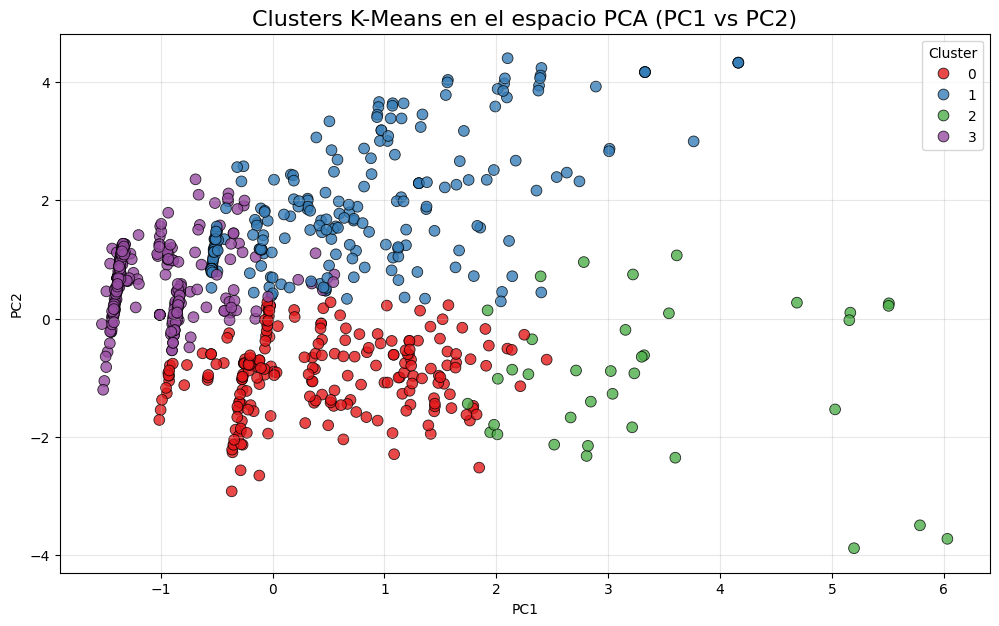

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))

sns.scatterplot(
    data=pca_pd,
    x="PC1",
    y="PC2",
    hue="prediction",
    palette="Set1",
    s=60,
    alpha=0.8,
    edgecolor="black"
)

plt.title("Clusters K-Means en el espacio PCA (PC1 vs PC2)", fontsize=16)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.legend(title="Cluster")
plt.show()

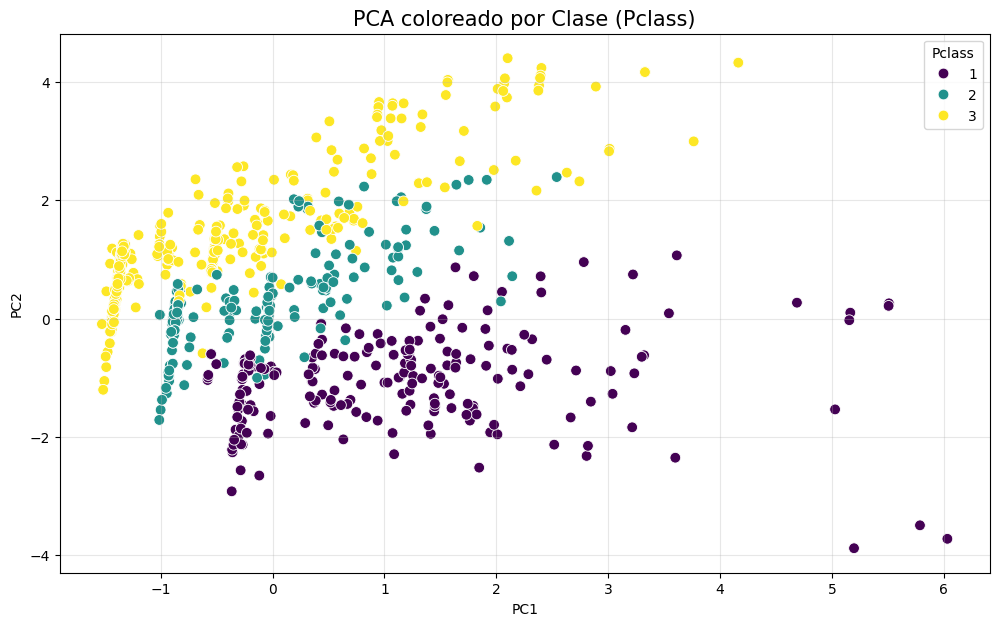

In [35]:
plt.figure(figsize=(12, 7))

sns.scatterplot(
    data=pca_pd,
    x="PC1",
    y="PC2",
    hue="Pclass",
    palette="viridis",
    s=60
)

plt.title("PCA coloreado por Clase (Pclass)", fontsize=15)
plt.grid(alpha=0.3)
plt.show()

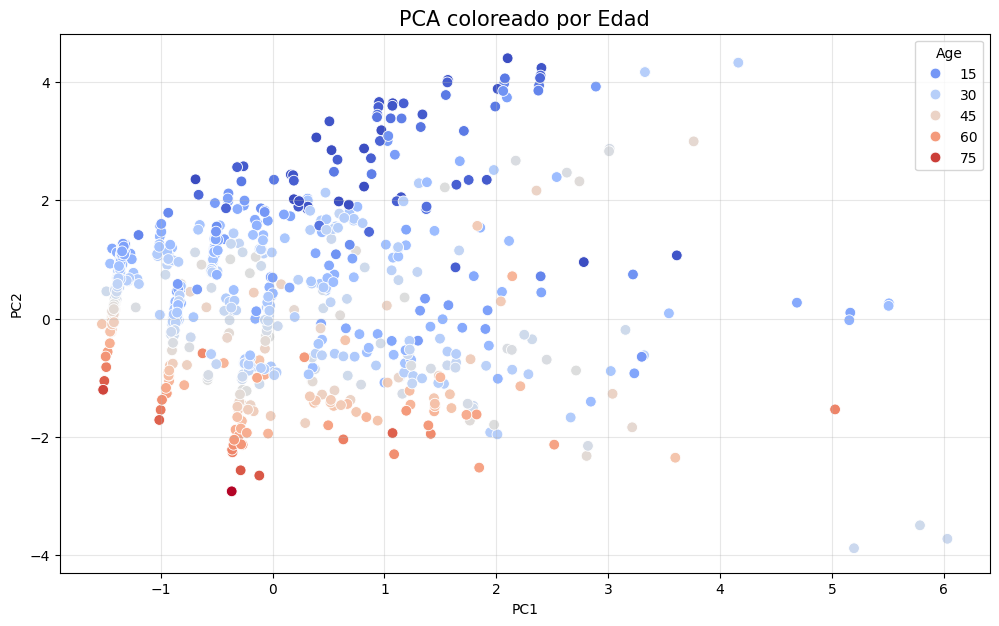

In [36]:
plt.figure(figsize=(12, 7))

sns.scatterplot(
    data=pca_pd,
    x="PC1",
    y="PC2",
    hue="Age",
    palette="coolwarm",
    s=60
)

plt.title("PCA coloreado por Edad", fontsize=15)
plt.grid(alpha=0.3)
plt.show()


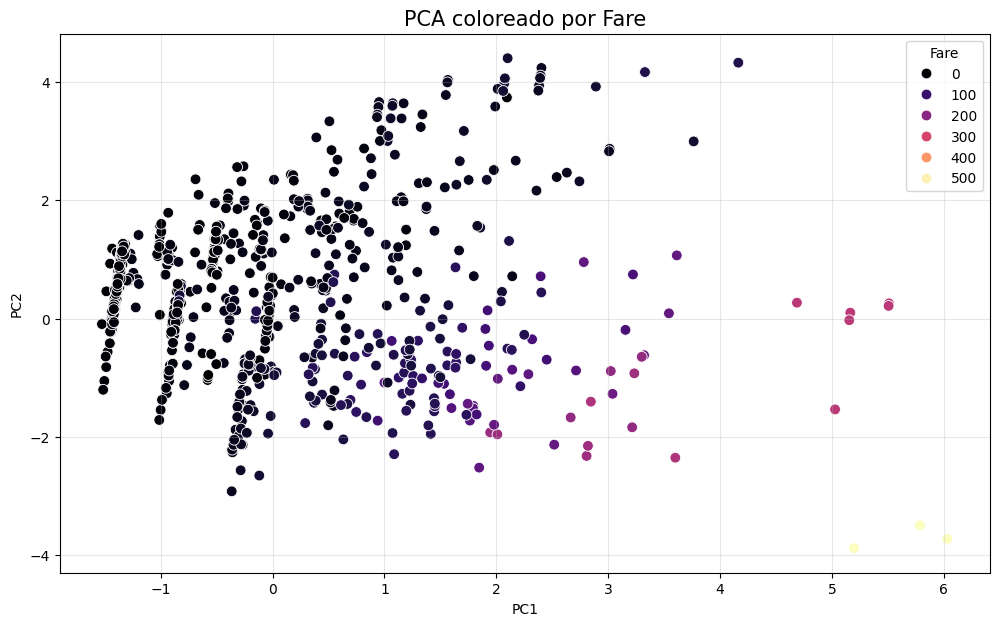

In [37]:
plt.figure(figsize=(12, 7))

sns.scatterplot(
    data=pca_pd,
    x="PC1",
    y="PC2",
    hue="Fare",
    palette="magma",
    s=60
)

plt.title("PCA coloreado por Fare", fontsize=15)
plt.grid(alpha=0.3)
plt.show()

# Conclusiones Finales

En este cuaderno se desarrolló un flujo completo de **aprendizaje no supervisado a gran escala** utilizando Apache Spark y MLlib, aplicado al dataset real del Titanic. A continuación se presenta un resumen detallado de los hallazgos más importantes y del aporte de cada etapa del proceso:

---

## 1. Preparación y Limpieza de Datos

Se ejecutaron múltiples técnicas de preprocesamiento adaptadas a entornos distribuidos:

- **Imputación de “Age” con la media** para evitar pérdida de información.
- **Eliminación de registros incompletos en “Fare”**, asegurando coherencia en los valores económicos.
- **Conversión de variables categóricas a numéricas** mediante `StringIndexer` (columna `SexIndexed`).
- **Vectorización de múltiples columnas** usando `VectorAssembler`, combinando variables socioeconómicas como `Pclass`, `Age`, `Fare` y relaciones familiares `SibSp`, `Parch`.

Estas transformaciones permitieron disponer de un conjunto de características limpio y compatible con los algoritmos de clustering.

---

## 2. Escalamiento de Características

Se aplicó `StandardScaler` para normalizar los datos:

- Reduciendo la influencia de variables con diferentes magnitudes (como `Fare` vs `SibSp`).  
- Asegurando que todos los atributos tengan una contribución balanceada en el clustering.  
- Preparando el dataset para PCA y K-Means, que dependen de la escala de los datos.

---

## 3. Clustering con K-Means

Se entrenaron modelos con **K = 2, 3 y 4** y se evaluaron con la métrica **Silhouette Score**, produciendo las siguientes conclusiones:

- El valor óptimo de K fue el que alcanzó el **mayor puntaje de Silhouette**, indicando una separación adecuada entre clusters y cohesión interna.  
- Los clusters generados mostraron patrones asociados con:
  - **Clase social** (`Pclass`)  
  - **Tarifa del ticket** (`Fare`)  
  - **Edad**  
  - **Sexo** (0 = male, 1 = female)

Esto evidencia que el clustering captura segmentaciones socioeconómicas claras dentro del dataset del Titanic.

---

## 4. Reducción de Dimensionalidad con PCA

Se aplicó PCA para reducir las 6 características a **dos componentes principales (PC1 y PC2)**. El análisis mostró que:

- PC1 concentra la mayor variabilidad y se correlaciona con las variables económicas (`Fare`, `Pclass`).  
- PC2 captura variabilidad relacionada con características demográficas (`Age`, `SexIndexed`).  
- La transformación facilitó una visualización clara de la estructura del espacio de características, donde se apreciaron grupos bien definidos.

---

## 5. Visualización del Clustering en Espacio PCA

Mediante un scatter plot de `PC1` vs `PC2`:

- Se observó una separación visible entre los clusters según patrones de edad, clase social y función familiar.
- Los clusters se alinearon con los valores extremos de `Fare` y `Pclass`, lo cual es consistente con segmentación socioeconómica típica del dataset Titanic.
- La combinación de PCA + K-Means permitió interpretar visualmente los grupos encontrados.

---

## 6. Contribución General del Taller

El proceso realizado en Spark:

- Demostró cómo ejecutar **pipelines de ML No Supervisado** sobre un clúster distribuido.
- Validó la importancia de escalar, vectorizar y limpiar correctamente los datos antes del clustering.
- Mostró cómo usar herramientas avanzadas como:
  - `VectorAssembler`
  - `StandardScaler`
  - `StringIndexer`
  - `PCA`
  - `KMeans`
  - `ClusteringEvaluator`
- Permitió extraer conclusiones sólidas apoyadas por evidencias visuales y métricas objetivas.

---

## Conclusión Final

Este taller evidenció que Spark MLlib proporciona un conjunto de herramientas robustas para ejecutar algoritmos de aprendizaje no supervisado a gran escala.  
La combinación de **PCA + K-Means**, aplicada sobre el dataset Titanic, permitió identificar segmentos significativos de pasajeros basados en características socioeconómicas y demográficas, confirmando patrones históricamente conocidos y abriendo la puerta a análisis más complejos.

En resumen, se logró:

- Procesar datos a escala distribuida  
- Transformarlos en un pipeline eficiente  
- Identificar clusters significativos  
- Visualizar grupos en espacios reducidos  

Esto constituye un flujo completo y reproducible para análisis no supervisado en entornos de Big Data.
